In [ ]:
# Working with dataframes and arrays
import pandas as pd
import numpy as np
import math

# Ploting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# NLP
import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from gensim import corpora

In [ ]:
# Modeling
from statsmodels.stats.outliers_influence import variance_inflation_factor
from mlxtend.preprocessing import DenseTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Cleaner notebook
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Read and preview data
df = pd.read_csv('/content/Womens Clothing E-Commerce Reviews.csv')

print(df.shape)
print(df.columns)
df.head()

(23486, 11)
Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
# Remove the column: 'Unnamed: 0'
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# Count the number of nulls in each column
df.isna().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [ ]:
# Count the number of unique values in each column
df.nunique()

Clothing ID                 1206
Age                           77
Title                      13993
Review Text                22634
Rating                         5
Recommended IND                2
Positive Feedback Count       82
Division Name                  3
Department Name                6
Class Name                    20
dtype: int64

In [ ]:
# Clean text data (remove special characters, lowercase, remove stop words, and lemmatize)

# I found this function for text preprocessing online. I think it was towardsdatascience.com,
# but I can't find/remember where I found it. If I find the site, I'll post the source to give the author credit.

def preprocess(raw_text):
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    words = letters_only_text.lower().split()

    cleaned_words = []
    lemmatizer = WordNetLemmatizer()

    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)

    lemmas = []
    for word in cleaned_words:
        word = lemmatizer.lemmatize(word)
        lemmas.append(word)

    return " ".join(lemmas)

df['Review Text'] = df['Review Text'].astype(str)
df['clean_review_text'] = df['Review Text'].apply(preprocess)

# Inspect the cleaned text data
df[['Review Text','clean_review_text']].head(3)

NameError: name 'stop_words' is not defined

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess(raw_text):
    cleaned_words = []
    words = raw_text.split()
    for word in words:
        if word.lower() not in stop_words:
            cleaned_words.append(word.lower())  # Convert to lowercase
    return ' '.join(cleaned_words)

# Assuming 'df' is your DataFrame and 'Review Text' is the column containing text data
df['Review Text'] = df['Review Text'].astype(str)
df['clean_review_text'] = df['Review Text'].apply(preprocess)

# Inspect the cleaned text data
print(df['clean_review_text'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0            absolutely wonderful - silky sexy comfortable
1        love dress! sooo pretty. happened find store, ...
2        high hopes dress really wanted work me. initia...
3        love, love, love jumpsuit. fun, flirty, fabulo...
4        shirt flattering due adjustable front tie. per...
                               ...                        
23481    happy snag dress great price! easy slip flatte...
23482    reminds maternity clothes. soft, stretchy, shi...
23483    fit well, top see through. never would worked ...
23484    bought dress wedding summer, cute. unfortunate...
23485    dress lovely platinum feminine fits perfectly,...
Name: clean_review_text, Length: 23486, dtype: object


In [ ]:
#Exploratory data analysis

Text(0.5, 1.0, 'Distribution of Product Net Polarity')

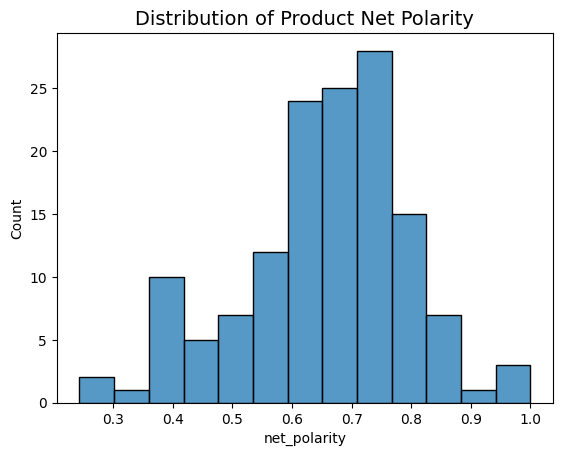

In [ ]:
# Count number of reviews for each product by rating
df_ratings = df.pivot_table(values='Review Text'
                            , index='Clothing ID'
                            , columns='Rating'
                            , aggfunc='count'
                            , margins=True
                            , margins_name='Total'
                            , fill_value=0)

# Use the percent of 1 and 2, and 4 and 5 star reviews to gauge if there are polarizing product
df_ratings['percent_5_star'] = (df_ratings[5] + df_ratings[4]) / df_ratings['Total']
df_ratings['percent_1_star'] = (df_ratings[1] + df_ratings[2]) / df_ratings['Total']
df_ratings['net_polarity'] = df_ratings['percent_5_star'] - df_ratings['percent_1_star']

# Filter out products with less than 30 reviews
df_ratings = df_ratings[df_ratings['Total'] >= 30]

# Distribution of product net polarity
sns.histplot(df_ratings['net_polarity'])
plt.title('Distribution of Product Net Polarity', fontsize=14)

In [ ]:
#Ratings

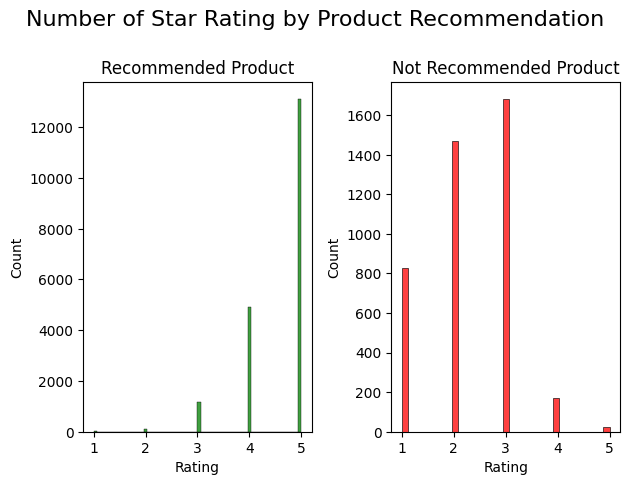

In [ ]:
# Distribution of star ratings by whehter the reviewer recommends the product
recommended = df[df['Recommended IND'] == 1]
not_recommended = df[df['Recommended IND'] == 0]

plt.subplot(1, 2, 1)
sns.histplot(recommended['Rating'], color='green')
plt.title('Recommended Product')

plt.subplot(1, 2, 2)
sns.histplot(not_recommended['Rating'], color='red')
plt.title('Not Recommended Product')
plt.suptitle('Number of Star Rating by Product Recommendation', fontsize=16, verticalalignment='center', horizontalalignment='center')
plt.tight_layout()
plt.show()

In [ ]:
#Number of characters and words in the review¶
#There's not a big difference in the number of words and characters a review contains whether they do or don't recommend the product.)

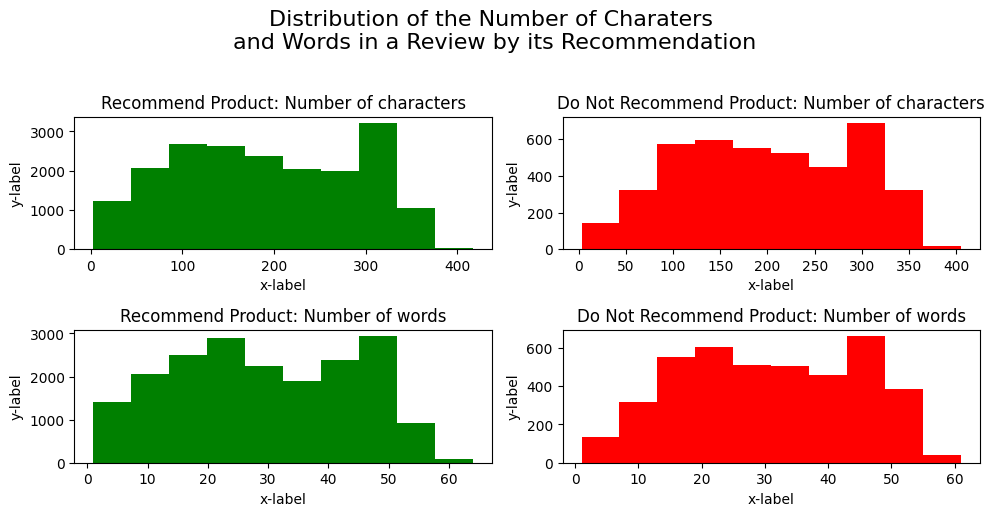

In [ ]:
# Number of characters in the review by whehter the reviewer recommends the product
df['num_characters'] = df['clean_review_text'].apply(len)

# Number of words in the review by whehter the reviewer recommends the product
df['num_words'] = [len(x.split()) for x in df['clean_review_text'].tolist()]

# Separate reviews that recommend and don't recommend the productd
recommend = df[df['Recommended IND'] == 1]
not_recommend = df[df['Recommended IND'] == 0]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(10,5))

axs[0, 0].hist(recommend['num_characters'], color='green')
axs[0, 0].set_title('Recommend Product: Number of characters')

axs[0, 1].hist(not_recommend['num_characters'], color='red')
axs[0, 1].set_title('Do Not Recommend Product: Number of characters')

axs[1, 0].hist(recommend['num_words'], color='green')
axs[1, 0].set_title('Recommend Product: Number of words')

axs[1, 1].hist(not_recommend['num_words'], color='red')
axs[1, 1].set_title('Do Not Recommend Product: Number of words')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

plt.suptitle('Distribution of the Number of Charaters \nand Words in a Review by its Recommendation', fontsize=16, verticalalignment='center', horizontalalignment='center')
fig.tight_layout()
plt.show()

In [ ]:
#Age of reviewe

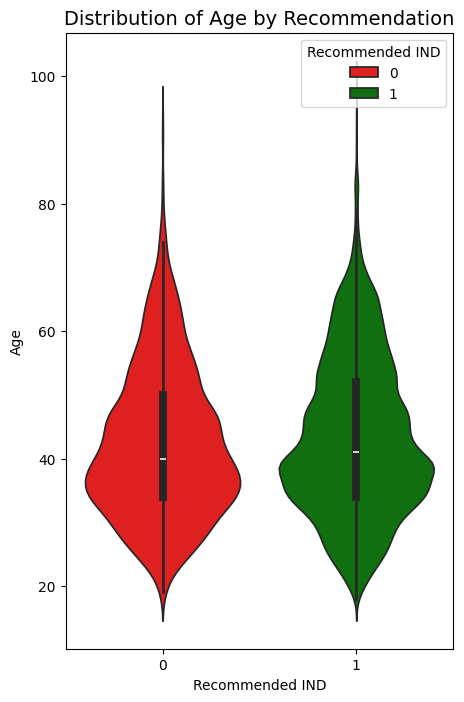

In [ ]:
# Distribution of Age by Recommendation
# Not a big difference in age between those that recommend and don't recommend the product
plt.figure(figsize=(5,8))
sns.violinplot(y='Age', x='Recommended IND', hue='Recommended IND', data=df, palette=['red', 'green'])
plt.title('Distribution of Age by Recommendation', fontsize=14)
plt.show()

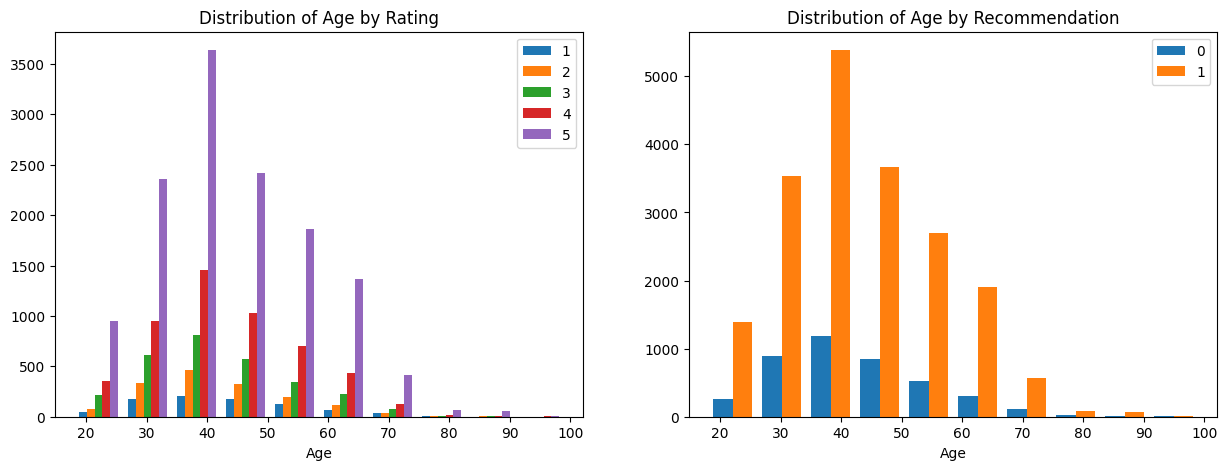

In [ ]:
# Each age group has a similar range of ratings and recommendations given.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
n_bins = 10

ratings = sorted(list(df.Rating.unique()))
x1 = [df[df.Rating == i]['Age'].to_numpy() for i in ratings]
ax1.hist(x1, n_bins, histtype='bar')
ax1.set_xlabel('Age')
ax1.legend(ratings)
ax1.set_title('Distribution of Age by Rating', fontsize=12)

rec = sorted(list(df['Recommended IND'].unique()))
x2 = [df[df['Recommended IND'] == i]['Age'].to_numpy() for i in rec]
ax2.hist(x2, n_bins, histtype='bar')
ax2.set_xlabel('Age')
ax2.legend(rec)
ax2.set_title('Distribution of Age by Recommendation', fontsize=12)

plt.show()

In [ ]:
# Binning age
age_bins = pd.qcut(df['Age'], q=6).rename('age_bins')
df = pd.concat([df, age_bins], axis=1)
df.age_bins.value_counts()

age_bins
(17.999, 32.0]    4538
(41.0, 48.0]      4279
(32.0, 37.0]      4046
(56.0, 99.0]      3739
(48.0, 56.0]      3477
(37.0, 41.0]      3407
Name: count, dtype: int64

In [ ]:
# Average rating for each age group
# The oldest age group (56 to 99 yo) has the highest average rating, but all age groups have pretty similar average ratings.
(df.groupby('age_bins')
 .agg({'Rating': 'mean', 'clean_review_text': 'count'})
 .reset_index()
 .rename(columns={'Rating': 'Average_Rating', 'clean_review_text': 'Num_reviews', 'age_bins': 'Age Groups'})
 .style.background_gradient(cmap = 'YlGn')
 .format({'Average_Rating':'{:.2f}', 'Num_reviews': '{:.0f}'}))

,Age Groups,Average_Rating,Num_reviews
0,"(17.999, 32.0]",4.19,4538
1,"(32.0, 37.0]",4.15,4046
2,"(37.0, 41.0]",4.21,3407
3,"(41.0, 48.0]",4.14,4279
4,"(48.0, 56.0]",4.22,3477
5,"(56.0, 99.0]",4.28,3739


In [ ]:
# Percent of ratings that come from each age group

# Most of the 1 ratings (worst) come from the 41 to 48 age group
# Most of the 5 ratings (best) come from the 56 to 99 age group
age_ratings = pd.pivot_table(data = df
              , values = 'clean_review_text'
              , index = 'age_bins'
              , columns = 'Rating'
              , aggfunc = 'count'
              , fill_value = 0
              , margins = True)

# Percent of column total
age_ratings_pct_col = age_ratings.copy()
for i in age_ratings.columns:
    age_ratings_pct_col[i] = age_ratings[i] / age_ratings.iloc[-1][i]

print('Percent of ratings that come from each age group')
rounded = dict()
for i in age_ratings_pct_col.columns:
    rounded[i] = "{:.2f}" # create a dictionary to format the decimals

age_ratings_pct_col.style.background_gradient(axis=1, cmap = 'YlGn').format(rounded)

Percent of ratings that come from each age group


Rating,1,2,3,4,5,All
age_bins,,,,,,
"(17.999, 32.0]",0.19,0.18,0.21,0.19,0.19,0.19
"(32.0, 37.0]",0.17,0.21,0.18,0.17,0.17,0.17
"(37.0, 41.0]",0.12,0.13,0.14,0.16,0.14,0.15
"(41.0, 48.0]",0.21,0.21,0.18,0.19,0.17,0.18
"(48.0, 56.0]",0.14,0.13,0.14,0.15,0.15,0.15
"(56.0, 99.0]",0.17,0.13,0.13,0.14,0.17,0.16
All,1.00,1.00,1.00,1.00,1.00,1.00


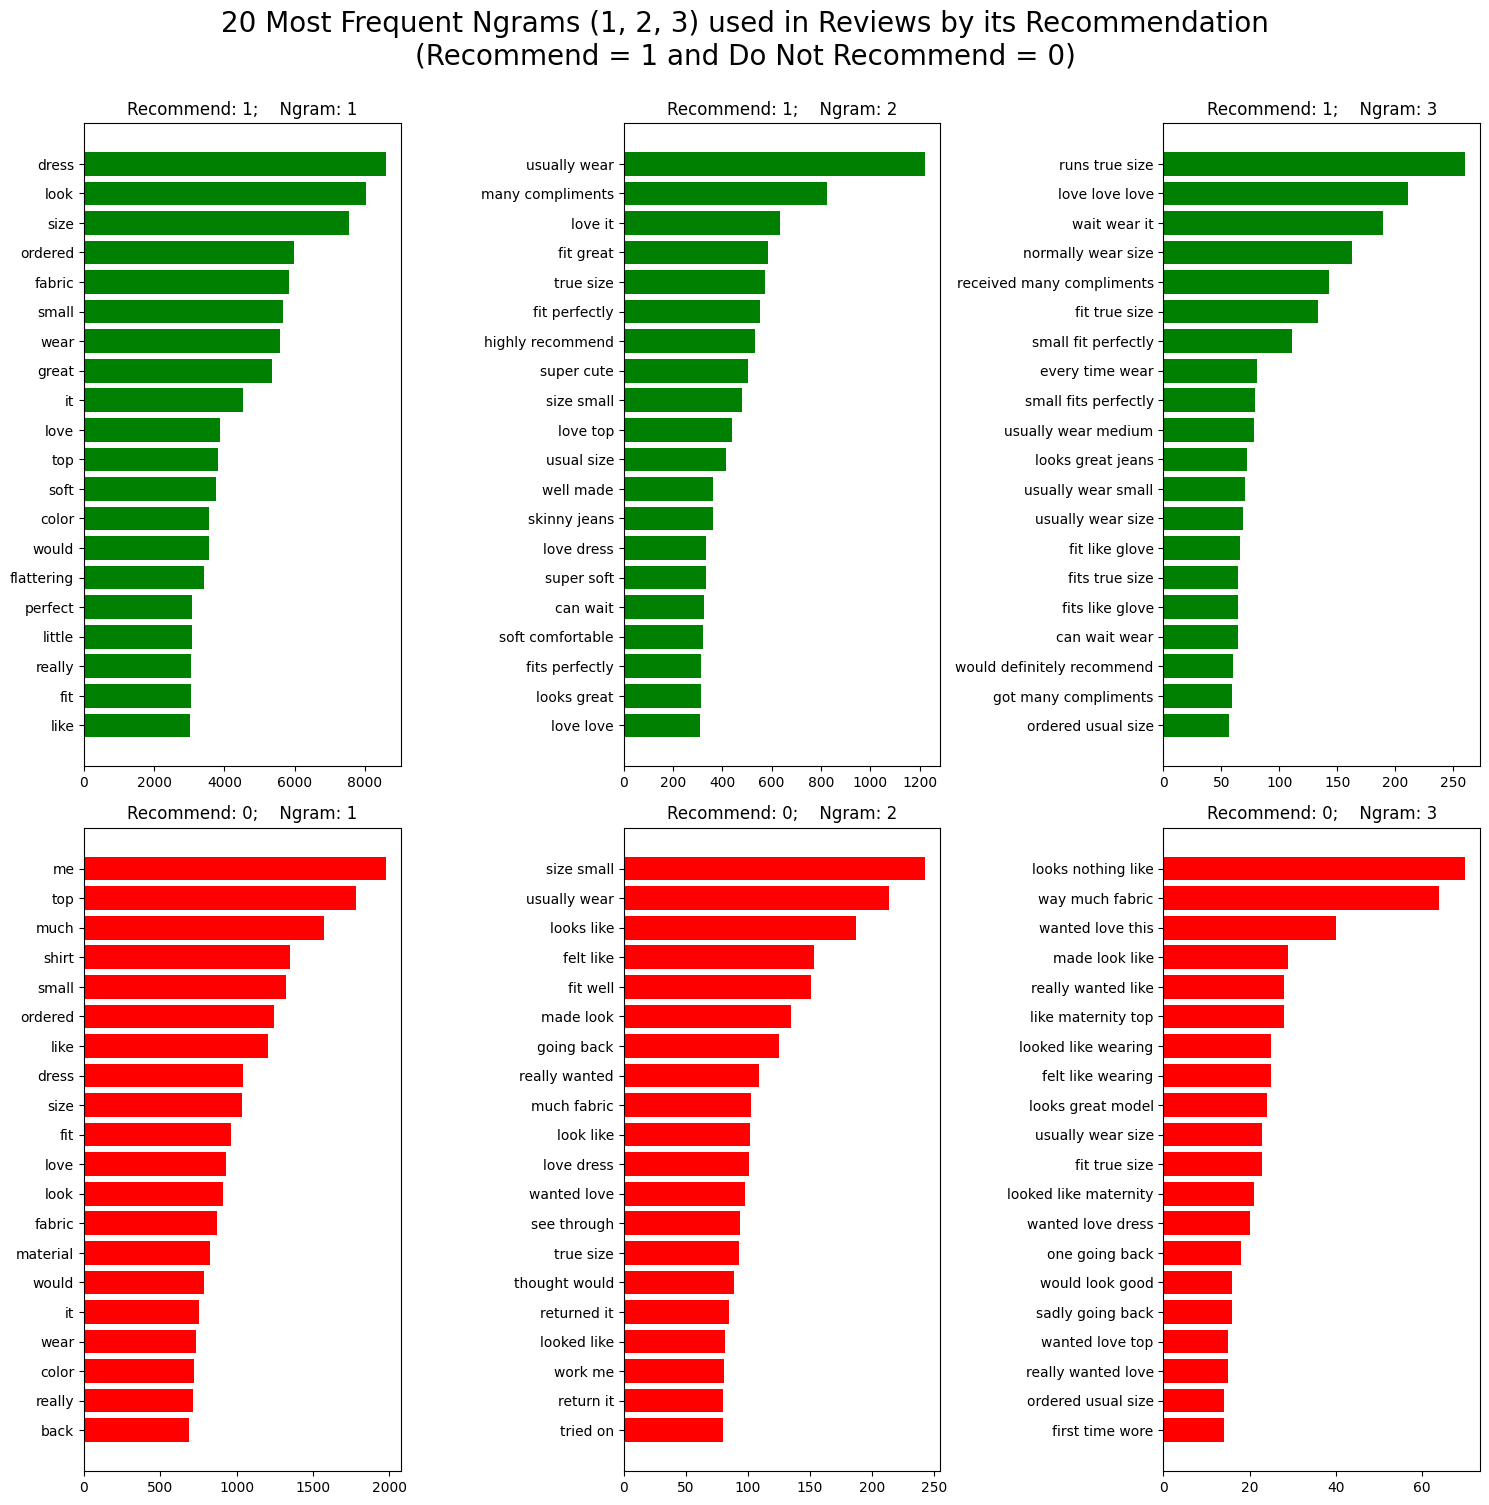

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Store ngrams for reviews that recommend and don't recommend the product in a dictionary
ngrams_dict = dict()

for i in sorted(df['Recommended IND'].unique(), reverse=True):
    X = df[df['Recommended IND'] == i]['clean_review_text']
    for n in range(1, 4):
        vectorizer = CountVectorizer(max_features=20, ngram_range=(n,n))
        DTM = vectorizer.fit_transform(X)
        frequencies = sum(DTM).toarray()[0]
        feature_names = list(vectorizer.vocabulary_.keys())
        ngrams = pd.DataFrame(frequencies, index=feature_names, columns=['Frequency'])
        ngrams.sort_values('Frequency', ascending=False, inplace=True)
        ngrams = ngrams.reset_index().rename(columns={'index': 'Term'})
        ngrams['ngram'] = n
        ngrams['recommend'] = i
        ngrams_dict[str(i) + '_' + str(n)] = ngrams

# Plot ngrams by recommendation
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, j in enumerate(list(ngrams_dict.keys())):
    i = i + 1
    to_plot = ngrams_dict[j]
    to_plot.sort_values('Frequency', inplace=True)
    not_rec_keys = ['0_1', '0_2', '0_3']
    if j in not_rec_keys:
        ax = fig.add_subplot(2, 3, i)
        ax.barh(to_plot.Term, to_plot.Frequency, color='red')
        ax.set_title("Recommend: " + str(j[:1]) + ";    Ngram: " + str(j[-1:]))
    else:
        ax = fig.add_subplot(2, 3, i)
        ax.barh(to_plot.Term, to_plot.Frequency, color='green')
        ax.set_title("Recommend: " + str(j[:1]) + ";    Ngram: " + str(j[-1:]))

plt.suptitle('20 Most Frequent Ngrams (1, 2, 3) used in Reviews by its Recommendation\n(Recommend = 1 and Do Not Recommend = 0)', fontsize=20, verticalalignment='center', horizontalalignment='center')
plt.tight_layout()
plt.show()


In [34]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# List of unique product classes
# Remove products with less than 10 reviews
class_reviews = df.groupby('Class Name').agg({'clean_review_text': 'nunique'})
classes = class_reviews[class_reviews.clean_review_text >= 10].index

# Use CountVectorizer to create a document term matrix (DTM) for each product's reviews
vectorizer = CountVectorizer()
DTM_clothes = pd.DataFrame()

# Create dictionary to store reviews for each product class
clothes_dict = dict()
for i, class_name in enumerate(classes):
    # Filter dataframe for reviews of the current product class
    reviews = df[df['Class Name'] == class_name]['clean_review_text']

    # Combine reviews into a single string
    combined_reviews = ' '.join(reviews)

    # Store combined reviews in dictionary
    clothes_dict[class_name] = combined_reviews

    # Convert combined reviews into a list for CountVectorizer
    review_list = [combined_reviews]

    # Create Document-Term Matrix (DTM) using CountVectorizer
    dtm = pd.DataFrame.sparse.from_spmatrix(vectorizer.fit_transform(review_list), columns=vectorizer.get_feature_names_out())

    # Transpose DTM for easier manipulation
    dtm = dtm.transpose()

    # Rename column with product class name
    dtm = dtm.rename(columns={0: class_name})

    # Merge current DTM with existing DTM DataFrame
    if i == 0:
        DTM_clothes = dtm
    else:
        DTM_clothes = DTM_clothes.join(dtm, how='outer')

# Fill missing values with 0
DTM_clothes.fillna(0, inplace=True)
DTM_clothes = DTM_clothes.transpose()

# Measure cosine similarity between the product reviews
cosine = pd.DataFrame(cosine_similarity(DTM_clothes), columns=DTM_clothes.index, index=DTM_clothes.index)
rounded_cosine = cosine.applymap(lambda x: round(x, 2))

# Display cosine similarity matrix
cosine.style.background_gradient(axis=1, cmap='YlGn')


,Blouses,Dresses,Fine gauge,Intimates,Jackets,Jeans,Knits,Layering,Legwear,Lounge,Outerwear,Pants,Shorts,Skirts,Sleep,Sweaters,Swim,Trend
Blouses,1.000000,0.627527,0.799601,0.752723,0.755252,0.668496,0.972817,0.838950,0.612990,0.839938,0.714028,0.753727,0.726241,0.633275,0.791994,0.714412,0.766860,0.788451
Dresses,0.627527,1.000000,0.618643,0.599398,0.627927,0.527036,0.634542,0.628812,0.501830,0.801880,0.595789,0.618426,0.587825,0.536275,0.679198,0.575558,0.565552,0.871792
Fine gauge,0.799601,0.618643,1.000000,0.730336,0.787012,0.667392,0.839939,0.785965,0.655036,0.835981,0.755681,0.743243,0.698231,0.630418,0.792159,0.972078,0.680905,0.759240
Intimates,0.752723,0.599398,0.730336,1.000000,0.729783,0.633274,0.778323,0.804171,0.630399,0.822771,0.689368,0.723826,0.697250,0.603858,0.788532,0.685895,0.739586,0.707816
Jackets,0.755252,0.627927,0.787012,0.729783,1.000000,0.667770,0.785135,0.763082,0.622230,0.847594,0.847205,0.744355,0.696944,0.623441,0.766344,0.780255,0.668911,0.762426
Jeans,0.668496,0.527036,0.667392,0.633274,0.667770,1.000000,0.675303,0.647810,0.655575,0.738011,0.611011,0.811748,0.712592,0.560575,0.710904,0.620799,0.605624,0.656544
Knits,0.972817,0.634542,0.839939,0.778323,0.785135,0.675303,1.000000,0.881836,0.651994,0.876793,0.726755,0.769921,0.743533,0.639017,0.822266,0.758255,0.760025,0.780785
Layering,0.838950,0.628812,0.785965,0.804171,0.763082,0.647810,0.881836,1.000000,0.660584,0.860787,0.713753,0.742426,0.711077,0.615906,0.793527,0.725271,0.714488,0.732121
Legwear,0.612990,0.501830,0.655036,0.630399,0.622230,0.655575,0.651994,0.660584,1.000000,0.753364,0.596682,0.712407,0.649688,0.526944,0.727092,0.637895,0.568284,0.591753
Lounge,0.839938,0.801880,0.835981,0.822771,0.847594,0.738011,0.876793,0.860787,0.753364,1.000000,0.786686,0.856594,0.796435,0.664659,0.912958,0.791641,0.750726,0.865825


In [35]:
# Find the most similar and dissimilar product reviews for each product class
sim = []
dis = []
for i in cosine.columns:
    spam = cosine.sort_values(i, ascending=False)
    eggs = spam.index[1] # the first value (index 0) will be itself so take the second highest value
    bacon = spam.index[-1]
    sim.append(eggs)
    dis.append(bacon)

sim_dis_reviews = pd.DataFrame({'Most_Similar': sim, 'Most_Dissimilar': dis}
                               , index = cosine.columns)

sim_dis_reviews

,Most_Similar,Most_Dissimilar
Blouses,Knits,Legwear
Dresses,Trend,Legwear
Fine gauge,Sweaters,Dresses
Intimates,Lounge,Dresses
Jackets,Lounge,Legwear
Jeans,Pants,Dresses
Knits,Blouses,Dresses
Layering,Knits,Skirts
Legwear,Lounge,Dresses
Lounge,Sleep,Skirts
